# Q5 A first Gibbs sampler (Lecture 7)

In [2]:
# load package
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import truncnorm as tnorm
from scipy.stats import multivariate_normal
import pandas as pd

The posterior distribution of s given t: $p(s|t) \propto p(t|s)*p(s)$, we can use the theorem 2 to compute the posterior distribution.

$p(s|t) = \mathcal N(s;\mu_{s|t}, \Sigma_{s|t})$  

$\Sigma_{s|t}=(\Sigma^{-1}+A^T\Sigma_{t|s}^{-1}A)^{-1}$

$\mu_{s|t} = \Sigma_{s|t}(\Sigma^{-1}\mu+A^T\Sigma_{t|s}^{-1}t)$ 



In [3]:
# p(s|t)
def prob_s_given_t_rvs(mu1, mu2, beta1, beta2, betat, t):
    cov_s_inv = np.linalg.inv(np.diag([beta1**2, beta2**2]))

    A = np.array([[1,-1]])

    mu = np.array([[mu1],[mu2]])
    
    cov_t_given_s_inv = 1/betat**2
    
    cov_s_given_t = np.linalg.inv(cov_s_inv + cov_t_given_s_inv * A.T@A)
    mu_s_given_t = cov_s_given_t@(cov_s_inv@mu + t * cov_t_given_s_inv * A.T)
    
    return multivariate_normal.rvs(mean=mu_s_given_t.flatten(), cov=cov_s_given_t)

# p(t|s,y)
def prob_t_given_s_y_rvs(s1, s2, betat, y):
    mu = s1 - s2
    if y == 1:
        return tnorm.rvs(a=-mu/betat, b=np.inf, loc=mu, scale=betat)
    else:
        return tnorm.rvs(a=-np.inf, b=-mu/betat, loc=mu, scale=betat)

# gibbs sampling    
def gibbs(K, mu1, mu2, beta1, beta2, betat, y, t0):
    s1 = np.zeros(K+1)
    s2 = np.zeros(K+1)
    t = np.zeros(K+1)
    t[0] = t0
    
    for k in range(1,K+1):
        s1[k], s2[k] = prob_s_given_t_rvs(mu1, mu2, beta1, beta2, betat, t[k-1])
        t[k] = prob_t_given_s_y_rvs(s1[k],s2[k], betat, y)
    return s1, s2, t    

def normal_distribution(x,mu, var):
    return 1/np.sqrt(2*np.pi*var)*np.exp(-(x-mu)**2/2/var)

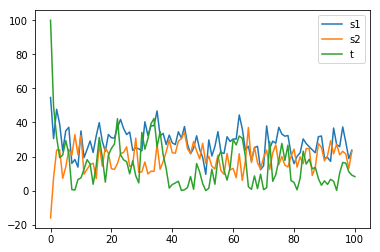

In [3]:
def init(K=100):
    # Initialize the prior distribution of s1 and s2
    mu1 = 25
    mu2 = 25
    beta1 = 25/3
    beta2 = 25/3

    betat = 25/3

    y = 1 # player 1 win the game
    
    # the initial value of t
    t0 = 100
    return mu1, mu2, beta1,beta2, betat, y, K, t0

mu1, mu2, beta1,beta2, betat, y, K, t0 = init()
s1, s2, t = gibbs(K, mu1, mu2, beta1, beta2, betat, y, t0)

plt.plot(s1[1:],label='s1')
plt.plot(s2[1:],label='s2')
plt.plot(t[:], label='t')
plt.legend(loc='upper right')

## Burn-in = 50
After the first run, we can see that s1, s2, and t are follow stationary distribution after around 50, so we choose 50 as burn-in.  
When we did second and third run, the results are the same.

In [4]:
burn_in = 50
mpost1 = np.mean(s1[burn_in:])
vpost1 = np.var(s1[burn_in:])
mpost2 = np.mean(s2[burn_in:])
vpost2 = np.var(s2[burn_in:])

print("Gaussian approximation of the posterior distribution of the player 1's skill is N(s1;{0:.2f},{1:.2f})".format(mpost1, vpost1))
print("Gaussian approximation of the posterior distribution of the player 2's skill is N(s1;{0:.2f},{1:.2f})".format(mpost2, vpost2))

Gaussian approximation of the posterior distribution of the player 1's skill is N(s1;26.21,49.99)
Gaussian approximation of the posterior distribution of the player 2's skill is N(s1;18.92,38.26)


### Tradeoff experiments

We fixes all the other parameters instead of K, the number of samples. Since we choose 50 as our burn-in value, so we need to record the time that samples after that.


In [4]:
import time
# we are supposed to do the experiment multiply times.
def gibbs_tradeOff(K, mu1, mu2, beta1, beta2, betat, y, t0, burn_in):
    s1 = np.zeros(K)
    s2 = np.zeros(K)
    t = np.zeros(K)
    t[0] = t0
    
    # record the start time
    start = 0
    
    for k in range(K):
        if k == burn_in:
            start = time.time()
        
        s1[k], s2[k] = prob_s_given_t_rvs(mu1, mu2, beta1, beta2, betat, t[k-1])
        t[k] = prob_t_given_s_y_rvs(s1[k],s2[k], betat, y)
    return s1[burn_in:], s2[burn_in:], t[burn_in:], time.time()-start

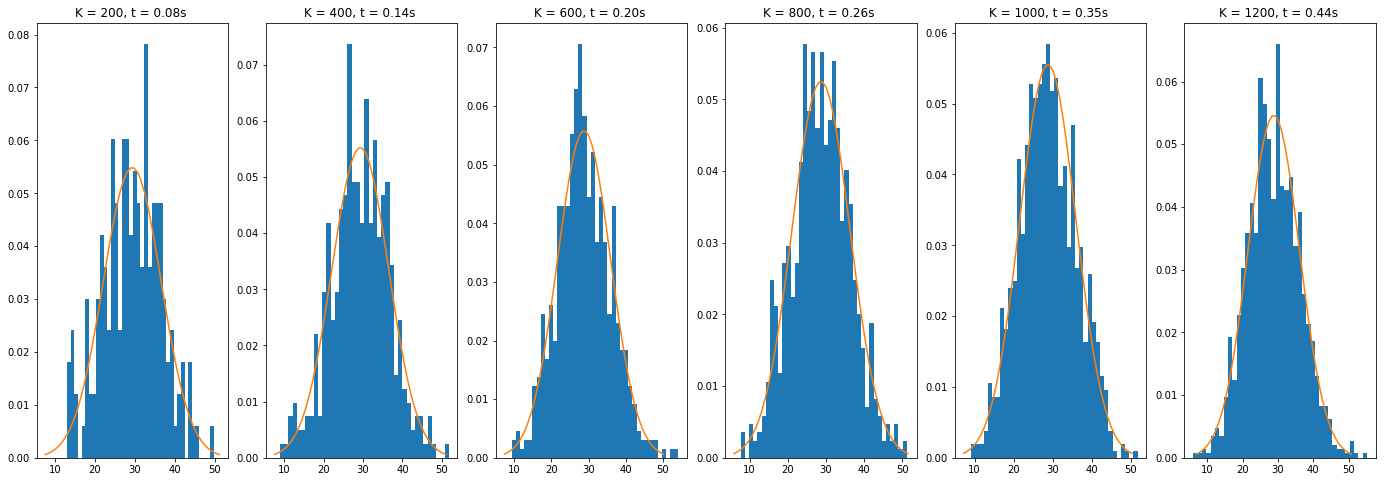

In [6]:
sample_size = 200
K = [sample_size + sample_size*i for i in range(6)]
burn_in = 20
s1_list = []
s2_list = []
time_list = []

for k in K:
    s1, s2, t, times = gibbs_tradeOff(k, mu1, mu2, beta1, beta2, betat, y, t0, burn_in)
    s1_list.append(s1)
    s2_list.append(s2)
    time_list.append(times)
    
plt.figure(figsize=(24,8))
for i in range(1,len(K)+1):
    mu1 = np.mean(s1_list[i-1])
    var1 = np.var(s1_list[i-1])
    time_spend = time_list[i-1]
    plt.subplot(1, len(K), i)
    
    x = np.linspace(mu1-3*np.sqrt(var1), mu1+3*np.sqrt(var1))
    plt.hist(s1_list[i-1], bins=40, density=True)

    plt.title("K = {}, t = {:.2f}s ".format(K[i-1], time_spend))
    plt.plot(x, normal_distribution(x, mu1, var1))
    
plt.savefig("trade-off", bbox_inches='tight', dpi=300)  

Here we choose the number of K in $\{200,400,600,800,1000,1200\}$ to do the trade-off experiments, we found when the sample size is larger, the shape of the histogram gets closer and closer to Gaussian distribution, which means more accuracy. When the sample size equals 600, the figure almost contains all the values of the distribution and the shape is similar to the Gaussian distribution. Although we increase the size of the sample, the shape tends to be more complete but with a high time cost, so we choose K = 600 as the reasonable number of samples.  

 Compare the prior $p(s_1)$ with the Gaussian approximation of the posterior $p(s_1|y = 1)$; similarly compare $p(s_2)$ with $p(s_2|y = 1)$. 
 
 In Figure\ref{Q5_3} , we can easily find the mean of the posterior distribution of $s_1$ that simulated by Gibbs sampling increased, and the mean of $s_2$ drops by the same amount. Since the result of the game is player 1 wins, so the skill of the player 1 will be higher than player 2, by propagation the mean and variance of skill of players change in some extent.

## Q6~7 Assumed Density Filtering and Prediction

In [5]:
# shuffle means if we need randomize the data
def init_Q6(shuffle=False):
    df = pd.read_csv('SerieA.csv')
    if shuffle:
        df = df.sample(frac=1)
        
    df['Result'] = df.apply(lambda a : np.sign(int(a['score1'])-int(a['score2'])), axis=1)
    skill_dict = {}
    
    mu = 25
    beta = 25/3
    
    # initilize the mu and beta
    for team in df['team1']:
        skill_dict[team] = {'mu':mu, 'beta':beta, 'win':0, 'lose':0}
    return df, skill_dict

In [6]:
def ADF(df, skill_dict,shuffle=False):    
    betat = 25/3
    burn_in = 50
    k = 600
    t0 = 30
    
    # prediction
    correct_guess = 0
    total_guess = 0
    
    for index, match in df.iterrows():
        team1 = match['team1']
        team2 = match['team2']
        result = match['Result']
        
        # if draw, skip the game
        if result == 0:
            continue
        if result == 1:
            skill_dict[team1]['win'] += 1
            skill_dict[team2]['lose'] += 1
        else:
            skill_dict[team2]['win'] += 1
            skill_dict[team1]['lose'] += 1
        
        # load the mu and beta of the prior
        mu1 = skill_dict[team1]['mu']
        mu2 = skill_dict[team2]['mu']
        beta1 = skill_dict[team1]['beta']
        beta2 = skill_dict[team2]['beta']   
        
        # make the prediction base on the prior
        y_pred = np.sign(mu1-mu2)        
        correct_guess += result == y_pred
        total_guess += 1 
                
        s1, s2, t = gibbs(k, mu1, mu2, beta1, beta2, betat, result, t0)
        
        # update the new mu and beta
        skill_dict[team1]['mu'] = np.mean(s1[burn_in:])
        skill_dict[team2]['mu'] = np.mean(s2[burn_in:])

        skill_dict[team1]['beta'] = np.std(s1[burn_in:])
        skill_dict[team2]['beta'] = np.std(s2[burn_in:])
    return skill_dict, correct_guess/total_guess, correct_guess/len(df)

def rank_skill(skill_dict, prediction_without_draw,prediction_with_draw,shuffle=False):
    ranked_skill_dict =sorted(skill_dict.items(),key=lambda x:x[1]['mu'], reverse=True)
    if shuffle:
        print("--------Result with Shuffling--------\n")
    else:
        print("--------Result without Shuffling--------\n")
    print("&%20.15s &%10.5s &%10.10s &%5.5s &%5.5s\\" % ('Team','Mean','Variance','Win','Lose'))
    
    rank_list = {}
    rank = 1
    
    for item in ranked_skill_dict:
        print("%20.15s %10.3f %10.3f %5.d %5.d" % (item[0],item[1]['mu'],item[1]['beta'],item[1]['win'],item[1]['lose']))
        rank_list[item[0]] = rank
        rank += 1

    print("\nThe accuracy of prediction without considering draw is %.3f" % prediction_without_draw)
    print("\nThe accuracy of prediction with considering draw is %.3f\n" % prediction_with_draw)
    
    return rank_list
    
def run_ADF(shuffle=False):
    df, skill_dict = init_Q6(shuffle)
    skill_dict, prediction_without_draw, prediction_with_draw = ADF(df, skill_dict, shuffle)
    rank_skill(skill_dict,prediction_without_draw,prediction_with_draw,shuffle)

### Train the model without&with data shuffling

In [9]:
# Run the ADF and get the prediction at the same time
# without shuffling
run_ADF()

# with shuffling
run_ADF(shuffle=True)

--------Result without Shuffling--------

&                Team &      Mean &  Variance &  Win & Lose\
            Juventus     34.739      2.456    28     4
              Napoli     31.354      2.842    24     7
               Milan     30.878      2.296    19     8
               Inter     29.695      2.025    20     9
                Roma     29.414      2.419    18     8
              Torino     29.345      2.202    16     7
            Atalanta     28.545      1.963    20     9
               Lazio     26.605      2.129    17    13
           Sampdoria     24.633      2.076    15    15
                Spal     23.715      2.072    11    18
             Udinese     22.974      2.396    11    17
               Genoa     22.873      2.023     8    16
             Bologna     22.826      2.452    11    16
               Parma     22.584      2.246    10    17
              Empoli     21.959      2.036    10    20
          Fiorentina     21.643      2.319     8    13
            Cagli

## Random Guessing

In [7]:
def random_guess(df):
    random_guess = np.sign(np.random.randn(len(df)))
    real_result =  np.array(list(df.Result))

    correct_guess = 0
    for i in range(len(random_guess)):
        if real_result[i] == 0:
            continue
        if random_guess[i] == real_result[i]:
            correct_guess+=1

    print("\nThe accuracy of predition by random guessing is %.3f " % (correct_guess/len(random_guess)))

In [11]:
df, _ = init_Q6()
random_guess(df)


The accuracy of predition by random guessing is 0.363 


# Q.9 A message-passing algorithm

## Define the calculation rules of Gaussian Distribution

In [8]:
def mutiplyGauss(m1, s1, m2, s2):
    s = 1/(1/s1+1/s2)
    m = (m1/s1+m2/s2)*s
    return m, s

def divideGauss(m1, s1, m2, s2):
    m, s = mutiplyGauss(m1, s1, m2, -s2) 
    return m, s

def truncGaussMM(a, b, m0, s0):
    a_scaled, b_scaled = (a - m0) / np.sqrt(s0), (b - m0) / np.sqrt(s0) 
    m = tnorm.mean(a_scaled, b_scaled, loc=m0, scale=np.sqrt(s0))
    s = tnorm.var(a_scaled, b_scaled, loc=m0, scale=np.sqrt(s0)) 
    return m, s

In [9]:
def Moment_matching(mu1, mu2, beta1, beta2, betat, y):
    # Message mu1, mu2 and covariance from node s1 and s2 (S) to factor f_st
    mu1_m = mu1
    mu1_s = beta1**2
    mu2_m = mu2
    mu2_s = beta2**2

    mut_s = betat**2
    # Message mu3 and mu4 equals to mu1 and mu2
    mu3_m = mu1_m
    mu3_s = mu1_s
    mu4_m = mu2_m
    mu4_s = mu2_s


    # Message mu3 from factor f_st to node t
    mu5_m = mu1 - mu2
    mu5_s = mu1_s + mu2_s + mut_s

    if y == 1:
        a, b = 0, 10000
    else:
        a, b = -10000, 0

    pt_m, pt_s = truncGaussMM(a, b, mu5_m, mu5_s)

    # compute the messgae from t to f_st
    mu8_m, mu8_s = divideGauss(pt_m, pt_s, mu5_m, mu5_s)

    # compute the message from f_st to s1
    mu9_m = mu2_m + mu8_m 
    mu9_s = mu2_s + mu8_s + mut_s

    mu10_m = mu1_m - mu8_m
    mu10_s = mu1_s + mu8_s + mut_s

    # compute the posterior of s1 and s2
    mu_s1, beta_s1 = mutiplyGauss(mu1_m, mu1_s, mu9_m, mu9_s)
    mu_s2, beta_s2 = mutiplyGauss(mu2_m, mu2_s, mu10_m, mu10_s)
    
    return mu_s1, mu_s2, beta_s1, beta_s2

In [14]:
mu1, mu2, beta1,beta2, betat, y, K, t0 = init()
mu_s1, mu_s2, beta_s1, beta_s2 = Moment_matching(mu1, mu2, beta1, beta2, betat, y)
print("Posterior distribution of player 1 by moment matching with mean = %.3f, var = %.3f" % (mu_s1,beta_s1))
print("Posterior distribution of player 2 by moment matching with mean = %.3f, var = %.3f" % (mu_s2,beta_s2))

Posterior distribution of player 1 by moment matching with mean = 28.839, var = 54.708
Posterior distribution of player 2 by moment matching with mean = 21.161, var = 54.708


### Plot the posteriors computed with message passing. In the same plot, show also the histogram and the Gaussian approximation from Gibbs sampling

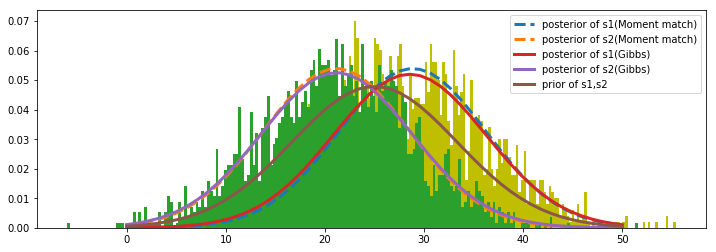

In [15]:
mu1, mu2, beta1,beta2, betat, y, K, t0 = init(K=2000)
burn_in = 50
s1, s2, t = gibbs(K, mu1, mu2, beta1, beta2, betat, y, t0)

mpost1 = np.mean(s1[burn_in:])
vpost1 = np.var(s1[burn_in:])
mpost2 = np.mean(s2[burn_in:])
vpost2 = np.var(s2[burn_in:])

skill = np.linspace(0,50)
plt.figure(figsize=(12,4))


plt.plot(skill, normal_distribution(skill, mu_s1, beta_s1),linewidth=3,linestyle='dashed', label='posterior of s1(Moment match)')
plt.plot(skill, normal_distribution(skill, mu_s2, beta_s2),linewidth=3,linestyle='dashed', label='posterior of s2(Moment match)')

plt.hist(s1[burn_in:], color='y',bins=200, density=True)
plt.hist(s2[burn_in:],bins=200, density=True)

plt.plot(skill, normal_distribution(skill,mpost1,vpost1),linewidth=3, label='posterior of s1(Gibbs)')
plt.plot(skill, normal_distribution(skill,mpost2,vpost2),linewidth=3, label='posterior of s2(Gibbs)')

plt.plot(skill, normal_distribution(skill,25,beta1**2),linewidth=3, label='prior of s1,s2')
plt.legend(loc='upper right')
plt.savefig("Q5")
plt.show()

# Q.10  Own data

## Step 1: Data loading

In [16]:
# Load the data
path = 'NBA/games.csv'
nba_df = pd.read_csv(path, usecols=['GAME_ID', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID','HOME_TEAM_WINS','SEASON'])

nba_df.head(10)

,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,HOME_TEAM_WINS
0,42000102,1610612755,1610612764,2020,1
1,42000132,1610612752,1610612737,2020,1
2,42000142,1610612762,1610612763,2020,1
3,42000112,1610612751,1610612738,2020,1
4,42000152,1610612756,1610612747,2020,0
5,42000172,1610612746,1610612742,2020,0
6,42000122,1610612749,1610612748,2020,1
7,42000162,1610612743,1610612757,2020,1
8,42000101,1610612755,1610612764,2020,1
9,42000151,1610612756,1610612747,2020,1


## Step 2: Data Preprocessing

In [17]:
# We only care about 
# which teams are involved in this match, 
# and which team won the game.
nba_df = nba_df[nba_df.SEASON == 2020]

# Game is time-sentitive, we need to sort it by time
nba_df.sort_values("GAME_ID",inplace=True)
nba_df.HOME_TEAM_WINS[nba_df.HOME_TEAM_WINS == 1] = 1
nba_df.HOME_TEAM_WINS[nba_df.HOME_TEAM_WINS == 0] = -1

# To make it more readable, we need to replace the teamID with teamName
team_name_Home = pd.read_csv('NBA/teams.csv',usecols=['TEAM_ID','NICKNAME'])
team_name_Home = team_name_Home.rename(columns={'TEAM_ID':'HOME_TEAM_ID'})
nba_df = pd.merge(nba_df, team_name_Home, how='left', on=['HOME_TEAM_ID'])
team_name_Home = team_name_Home.rename(columns={'HOME_TEAM_ID':'VISITOR_TEAM_ID'})
nba_df = pd.merge(nba_df, team_name_Home, how='left', on=['VISITOR_TEAM_ID'])
nba_df = nba_df.rename(columns={'NICKNAME_x':'team1','NICKNAME_y':'team2'})

# Rename the columns, to make it consistent with our model
nba_df = nba_df.rename(columns={'HOME_TEAM_WINS':'Result'})
nba_df.drop(['HOME_TEAM_ID','VISITOR_TEAM_ID','SEASON'], inplace=True, axis=1)
nba_df.head(10)

,GAME_ID,Result,team1,team2
0,12000001,-1,Hawks,Magic
1,12000002,-1,Pistons,Knicks
2,12000003,-1,Bulls,Rockets
3,12000004,1,Lakers,Clippers
4,12000005,1,Trail Blazers,Kings
5,12000006,-1,Hornets,Raptors
6,12000007,1,Cavaliers,Pacers
7,12000008,-1,Spurs,Thunder
8,12000009,-1,Bucks,Mavericks
9,12000010,-1,Timberwolves,Grizzlies


### Load the rank of the teams

In [18]:
# load the data of real rank of final season 
real_rank = pd.read_csv('NBA/ranking.csv', usecols=['TEAM_ID','TEAM','SEASON_ID'])
real_rank = real_rank[real_rank.SEASON_ID == 22020]

team_name = pd.read_csv('NBA/teams.csv',usecols=['TEAM_ID','NICKNAME'])
real_rank = pd.merge(real_rank, team_name, how='left', on=['TEAM_ID'])

rank_list = list(real_rank.NICKNAME)

rank_list_distinct = sorted(set(rank_list),key=rank_list.index)
rank = [1+i for i in range(len(rank_list_distinct))]
real_rank = dict(zip(rank_list_distinct, rank))

## Step 3: Verify the Gibbs sampler 

In [19]:
def init_Q10(df):
    skill_dict = {}

    mu = 25
    beta = 25/3
    
    team = set(df.team1) & set(df.team2)
    
    # initilize the mu and beta
    for team_name in team:
        skill_dict[team_name] = {'mu':mu, 'beta':beta, 'win':0, 'lose':0}

    return skill_dict
    
def verify_gibbs(df, shuffle=False):
    skill_dict = init_Q10(df)
    skill_dict, prediction_without_draw, prediction_with_draw = ADF(df, skill_dict, shuffle)
    return rank_skill(skill_dict,prediction_without_draw, prediction_with_draw,shuffle)
    
def mean_square_error(y_pred, y_true):
    sum = 0
    for key in y_pred:
        sum += (y_pred[key]-y_true[key])**2
    return sum**0.5/len(y_pred)

In [20]:
y_pred = verify_gibbs(nba_df)
print("\nMean Square error:", mean_square_error(y_pred, real_rank))

--------Result without Shuffling--------

&                Team &      Mean &  Variance &  Win & Lose\
                Suns     29.910      1.209    57    27
                Jazz     29.842      1.558    57    23
               76ers     29.283      1.131    55    23
             Nuggets     28.292      0.998    51    29
            Clippers     27.901      1.232    49    31
                Nets     27.881      1.359    54    28
              Lakers     27.648      1.361    50    32
               Bucks     27.462      1.088    51    31
           Grizzlies     26.970      1.122    46    38
              Knicks     26.874      1.308    47    34
               Hawks     26.768      1.250    49    35
       Trail Blazers     26.747      1.459    46    35
           Mavericks     26.212      1.034    47    34
                Heat     26.171      1.234    43    38
            Warriors     26.069      1.247    42    37
              Pacers     25.518      1.119    37    42
            Pelic

## Step 4: Verify the moment match

In [21]:
def verify_moment_match(df):
    skill_dict = init_Q10(df)
    betat = 25/3
    
    correct_guess = 0
    total_guess = 0
    
    for index, match in df.iterrows():
        team1 = match['team1']
        team2 = match['team2']
        result = match['Result']
        if result == 0:
            continue
        if result == 1:
            skill_dict[team1]['win'] += 1
            skill_dict[team2]['lose'] += 1
        else:
            skill_dict[team2]['win'] += 1
            skill_dict[team1]['lose'] += 1

        
        mu1 = skill_dict[team1]['mu']
        mu2 = skill_dict[team2]['mu']
        beta1 = skill_dict[team1]['beta']
        beta2 = skill_dict[team2]['beta']    
        
        # make the prediction base on the prior
        y_pred = np.sign(mu1-mu2)        
        correct_guess += result == y_pred
        total_guess += 1 
        
        mu_s1, mu_s2, beta_s1, beta_s2 = Moment_matching(mu1, mu2, beta1, beta2, betat, result)

        skill_dict[team1]['mu'], skill_dict[team1]['beta'] = mu_s1, np.sqrt(beta_s1)
        skill_dict[team2]['mu'], skill_dict[team2]['beta'] = mu_s2, np.sqrt(beta_s2)
    # output the result
    return rank_skill(skill_dict, correct_guess/total_guess, correct_guess/len(df))

In [22]:
y_pred = verify_moment_match(nba_df)
print("\nMean Square error:", mean_square_error(y_pred, real_rank))

--------Result without Shuffling--------

&                Team &      Mean &  Variance &  Win & Lose\
                Jazz     29.999      1.322    57    23
                Suns     29.652      1.256    57    27
               76ers     29.488      1.332    55    23
                Nets     28.570      1.244    54    28
             Nuggets     28.469      1.255    51    29
               Bucks     27.936      1.235    51    31
            Clippers     27.921      1.260    49    31
              Lakers     27.313      1.261    50    32
       Trail Blazers     26.998      1.244    46    35
           Mavericks     26.939      1.225    47    34
               Hawks     26.809      1.228    49    35
              Knicks     26.780      1.236    47    34
           Grizzlies     26.606      1.232    46    38
            Warriors     25.682      1.239    42    37
                Heat     25.597      1.232    43    38
             Celtics     24.424      1.242    37    43
              Pac

## Step 5: Random Guess

In [23]:
random_guess(nba_df)


The accuracy of predition by random guessing is 0.491 


# Q.11  Open-ended project extension

In [10]:
# use other dataset, we use data from 16-17 and 17-18 SerieA
# shuffle means if we need randomize the data
def init_Q11(shuffle=False):
    df_pre = pd.read_csv('season-1718_csv.csv')[['HomeTeam','AwayTeam','FTHG','FTAG']].rename(columns={'HomeTeam':'team1','AwayTeam':'team2','FTHG':'score1','FTAG':'score2'})
    df = pd.read_csv('SerieA.csv')
    if shuffle:
        df = df.sample(frac=1)
        df_pre = df_pre.sample(frac=1)
        
    df['Result'] = df.apply(lambda a : np.sign(int(a['score1'])-int(a['score2'])), axis=1)
    df_pre['Result'] = df_pre.apply(lambda a : np.sign(int(a['score1'])-int(a['score2'])), axis=1)
    skill_dict = {}
    
    mu = 25
    beta = 25/3
    
    # initilize the mu and beta
    for team in pd.concat([df_pre['team1'],df['team1']]):
        skill_dict[team] = {'mu':mu, 'beta':beta, 'win':0, 'lose':0}
    return df_pre, df, skill_dict

# Method 1

In [11]:
df_pre, df, skill_dict = init_Q11(False)
skill_dict, prediction_without_draw_pre, prediction_with_draw_pre = ADF(df_pre, skill_dict, False)
for key in skill_dict:
    skill_dict[key]['win'] = 0
    skill_dict[key]['lose'] = 0
skill_dict, prediction_without_draw, prediction_with_draw = ADF(df, skill_dict, False)
rank_skill(skill_dict,prediction_without_draw,prediction_with_draw,False)

--------Result without Shuffling--------

&                Team &      Mean &  Variance &  Win & Lose\
            Juventus     37.115      2.086    28     4
              Napoli     34.641      1.998    24     7
                Roma     30.799      1.319    18     8
               Milan     29.998      1.751    19     8
               Inter     29.775      1.588    20     9
               Lazio     29.027      1.940    17    13
              Torino     28.803      1.418    16     7
            Atalanta     28.619      1.651    20     9
           Sampdoria     25.399      1.517    15    15
          Fiorentina     24.596      1.570     8    13
            Sassuolo     23.271      1.437     9    13
               Parma     22.756      2.264    10    17
                Spal     22.344      1.495    11    18
              Empoli     22.297      1.899    10    20
             Udinese     22.032      0.991    11    17
               Genoa     22.019      1.692     8    16
            Cagli

{'Juventus': 1,
 'Napoli': 2,
 'Roma': 3,
 'Milan': 4,
 'Inter': 5,
 'Lazio': 6,
 'Torino': 7,
 'Atalanta': 8,
 'Sampdoria': 9,
 'Fiorentina': 10,
 'Sassuolo': 11,
 'Parma': 12,
 'Spal': 13,
 'Empoli': 14,
 'Udinese': 15,
 'Genoa': 16,
 'Cagliari': 17,
 'Bologna': 18,
 'Crotone': 19,
 'Frosinone': 20,
 'Chievo': 21,
 'Verona': 22,
 'Benevento': 23}

# Method 2

In [12]:
df_pre, df, skill_dict = init_Q11(False)
skill_dict, prediction_without_draw_pre, prediction_with_draw_pre = ADF(df_pre, skill_dict, False)
for key in skill_dict:
    skill_dict[key]['win'] = 0
    skill_dict[key]['lose'] = 0
    skill_dict[key]['beta'] = 25/3
skill_dict, prediction_without_draw, prediction_with_draw = ADF(df, skill_dict, False)
rank_skill(skill_dict,prediction_without_draw,prediction_with_draw,False)

--------Result without Shuffling--------

&                Team &      Mean &  Variance &  Win & Lose\
            Juventus     34.781      3.108    28     4
              Napoli     34.409      2.559    24     7
               Milan     32.732      2.853    19     8
              Torino     31.581      2.840    16     7
                Roma     30.453      2.063    18     8
               Inter     30.451      2.026    20     9
            Atalanta     29.892      1.629    20     9
               Lazio     28.850      2.217    17    13
           Sampdoria     25.993      2.037    15    15
                Spal     24.908      2.359    11    18
          Fiorentina     24.746      2.168     8    13
             Bologna     24.408      2.096    11    16
             Udinese     23.683      2.325    11    17
              Empoli     23.621      2.275    10    20
            Sassuolo     23.297      2.565     9    13
            Cagliari     23.239      2.109    10    17
               Pa

{'Juventus': 1,
 'Napoli': 2,
 'Milan': 3,
 'Torino': 4,
 'Roma': 5,
 'Inter': 6,
 'Atalanta': 7,
 'Lazio': 8,
 'Sampdoria': 9,
 'Spal': 10,
 'Fiorentina': 11,
 'Bologna': 12,
 'Udinese': 13,
 'Empoli': 14,
 'Sassuolo': 15,
 'Cagliari': 16,
 'Parma': 17,
 'Genoa': 18,
 'Frosinone': 19,
 'Crotone': 20,
 'Verona': 21,
 'Benevento': 22,
 'Chievo': 23}

# Method 3

In [19]:
df_pre, df, skill_dict = init_Q11(False)
skill_dict, prediction_without_draw_pre, prediction_with_draw_pre = ADF(df_pre, skill_dict, False)
for key in skill_dict:
    skill_dict[key]['win'] = 0
    skill_dict[key]['lose'] = 0
skill_dict['Empoli']['mu'] = skill_dict['Crotone']['mu'] 
skill_dict['Parma']['mu'] = skill_dict['Verona']['mu'] 
skill_dict['Frosinone']['mu'] = skill_dict['Benevento']['mu'] 
skill_dict['Empoli']['beta'] = skill_dict['Crotone']['beta'] 
skill_dict['Parma']['beta'] = skill_dict['Verona']['beta'] 
skill_dict['Frosinone']['beta'] = skill_dict['Benevento']['beta'] 
skill_dict, prediction_without_draw, prediction_with_draw = ADF(df, skill_dict, False)
rank_skill(skill_dict,prediction_without_draw,prediction_with_draw,False)

--------Result without Shuffling--------

&                Team &      Mean &  Variance &  Win & Lose\
            Juventus     36.106      1.918    28     4
              Napoli     33.028      1.658    24     7
                Roma     30.868      1.698    18     8
               Milan     30.025      1.650    19     8
               Inter     29.004      1.694    20     9
               Lazio     28.952      1.587    17    13
              Torino     27.575      2.062    16     7
            Atalanta     27.500      1.256    20     9
          Fiorentina     24.847      1.193     8    13
           Sampdoria     24.044      1.500    15    15
            Sassuolo     22.718      1.615     9    13
             Udinese     22.238      1.619    11    17
                Spal     21.911      1.325    11    18
             Bologna     21.886      1.710    11    16
               Genoa     21.665      1.893     8    16
            Cagliari     20.889      1.688    10    17
              Emp

{'Juventus': 1,
 'Napoli': 2,
 'Roma': 3,
 'Milan': 4,
 'Inter': 5,
 'Lazio': 6,
 'Torino': 7,
 'Atalanta': 8,
 'Fiorentina': 9,
 'Sampdoria': 10,
 'Sassuolo': 11,
 'Udinese': 12,
 'Spal': 13,
 'Bologna': 14,
 'Genoa': 15,
 'Cagliari': 16,
 'Empoli': 17,
 'Parma': 18,
 'Crotone': 19,
 'Chievo': 20,
 'Frosinone': 21,
 'Verona': 22,
 'Benevento': 23}

# Method 4

In [20]:
df_pre, df, skill_dict = init_Q11(False)
skill_dict, prediction_without_draw_pre, prediction_with_draw_pre = ADF(df_pre, skill_dict, False)
for key in skill_dict:
    skill_dict[key]['win'] = 0
    skill_dict[key]['lose'] = 0
    skill_dict[key]['beta'] = 25/3
skill_dict['Empoli']['mu'] = skill_dict['Crotone']['mu'] 
skill_dict['Parma']['mu'] = skill_dict['Verona']['mu'] 
skill_dict['Frosinone']['mu'] = skill_dict['Benevento']['mu'] 
skill_dict, prediction_without_draw, prediction_with_draw = ADF(df, skill_dict, False)
rank_skill(skill_dict,prediction_without_draw,prediction_with_draw,False)

--------Result without Shuffling--------

&                Team &      Mean &  Variance &  Win & Lose\
            Juventus     36.264      2.560    28     4
              Napoli     33.174      2.363    24     7
               Milan     31.875      2.411    19     8
            Atalanta     30.446      2.374    20     9
                Roma     29.602      2.358    18     8
              Torino     29.414      2.626    16     7
               Inter     29.309      1.976    20     9
               Lazio     26.880      2.135    17    13
           Sampdoria     25.241      2.053    15    15
                Spal     23.599      2.069    11    18
             Bologna     23.045      2.369    11    16
              Empoli     22.509      2.505    10    20
             Udinese     22.460      2.063    11    17
            Sassuolo     22.341      2.423     9    13
          Fiorentina     21.976      2.726     8    13
               Genoa     21.924      2.582     8    16
            Cagli

{'Juventus': 1,
 'Napoli': 2,
 'Milan': 3,
 'Atalanta': 4,
 'Roma': 5,
 'Torino': 6,
 'Inter': 7,
 'Lazio': 8,
 'Sampdoria': 9,
 'Spal': 10,
 'Bologna': 11,
 'Empoli': 12,
 'Udinese': 13,
 'Sassuolo': 14,
 'Fiorentina': 15,
 'Genoa': 16,
 'Cagliari': 17,
 'Parma': 18,
 'Crotone': 19,
 'Frosinone': 20,
 'Verona': 21,
 'Benevento': 22,
 'Chievo': 23}